In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import scanpy as sc

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

# Output folders (relative to notebook location)
Path("results/figures").mkdir(parents=True, exist_ok=True)
Path("results/metrics").mkdir(parents=True, exist_ok=True)
Path("results/models").mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
adata = sc.datasets.pbmc3k_processed()  # auto-download + cached
adata

  0%|          | 0.00/23.5M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [5]:
# Select HVGs
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var["highly_variable"]].copy()

# Labels (proxy)
if "louvain" not in adata.obs:
    raise ValueError("Expected adata.obs['louvain'] in pbmc3k_processed")
labels = adata.obs["louvain"].astype(str).values

classes = np.unique(labels)
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

y = np.array([class_to_idx[c] for c in labels], dtype=np.int64)

X = adata.X
if not isinstance(X, np.ndarray):
    X = X.toarray()
X = X.astype(np.float32)

print("X shape:", X.shape)
print("Num classes:", len(classes))
print(pd.Series(labels).value_counts())

X shape: (2638, 1838)
Num classes: 8
CD4 T cells          1144
CD14+ Monocytes       480
B cells               342
CD8 T cells           316
NK cells              154
FCGR3A+ Monocytes     150
Dendritic cells        37
Megakaryocytes         15
Name: count, dtype: int64


In [7]:
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=42, stratify=y_tmp
)

print("Train/Val/Test:", X_train.shape, X_val.shape, X_test.shape)

Train/Val/Test: (1846, 1838) (396, 1838) (396, 1838)


In [9]:
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 128
train_loader = DataLoader(NumpyDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(NumpyDataset(X_val, y_val),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(NumpyDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

In [11]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=X.shape[1], num_classes=len(classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

sum(p.numel() for p in model.parameters())

1074952

In [13]:
def run_epoch(loader, train=True):
    model.train(train)
    total_loss, correct, total = 0.0, 0, 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        if train:
            optimizer.zero_grad()

        logits = model(xb)
        loss = loss_fn(logits, yb)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)

    return total_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

best_val_loss = float("inf")
best_state = None
patience = 8
pat_left = patience

epochs = 50
for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")

    if va_loss < best_val_loss - 1e-4:
        best_val_loss = va_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        pat_left = patience
    else:
        pat_left -= 1
        if pat_left <= 0:
            print("Early stopping.")
            break

model.load_state_dict(best_state)

Epoch 01 | train loss 1.1963 acc 0.592 | val loss 0.4899 acc 0.851
Epoch 02 | train loss 0.2407 acc 0.943 | val loss 0.2193 acc 0.932
Epoch 03 | train loss 0.0540 acc 0.987 | val loss 0.1882 acc 0.939
Epoch 04 | train loss 0.0162 acc 0.998 | val loss 0.1589 acc 0.949
Epoch 05 | train loss 0.0047 acc 0.999 | val loss 0.1659 acc 0.947
Epoch 06 | train loss 0.0015 acc 1.000 | val loss 0.1726 acc 0.947
Epoch 07 | train loss 0.0013 acc 1.000 | val loss 0.1701 acc 0.947
Epoch 08 | train loss 0.0008 acc 1.000 | val loss 0.1696 acc 0.949
Epoch 09 | train loss 0.0006 acc 1.000 | val loss 0.1710 acc 0.949
Epoch 10 | train loss 0.0007 acc 1.000 | val loss 0.1727 acc 0.949
Epoch 11 | train loss 0.0005 acc 1.000 | val loss 0.1759 acc 0.952
Epoch 12 | train loss 0.0004 acc 1.000 | val loss 0.1766 acc 0.949
Early stopping.


<All keys matched successfully>

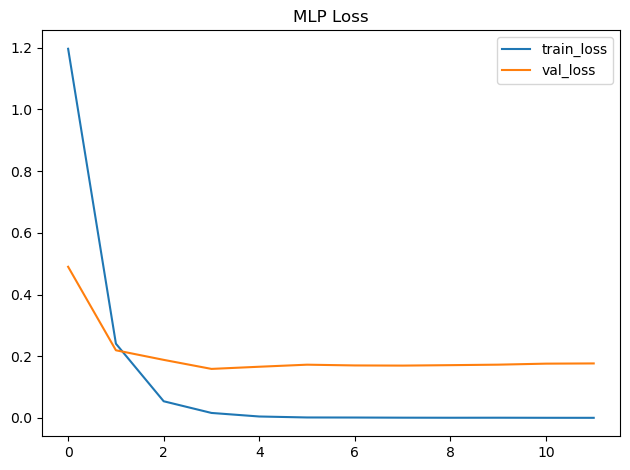

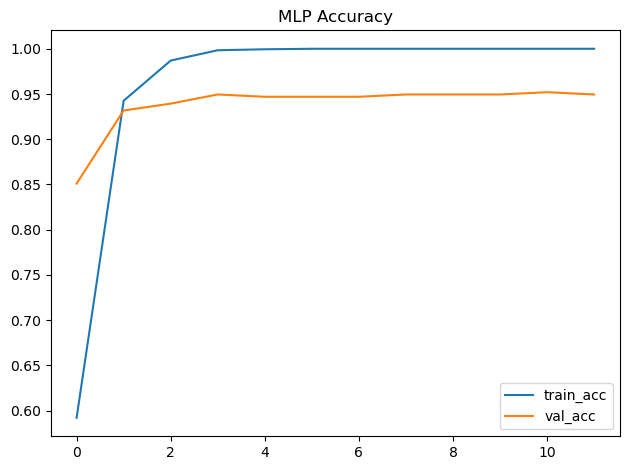

In [15]:
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend()
plt.title("MLP Loss")
plt.tight_layout()
plt.savefig("results/figures/mlp_loss.png", dpi=200)
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.legend()
plt.title("MLP Accuracy")
plt.tight_layout()
plt.savefig("results/figures/mlp_accuracy.png", dpi=200)
plt.show()

In [17]:
model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_true.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_true)

print(classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in range(len(classes))]))

report_dict = classification_report(
    y_true, y_pred,
    target_names=[idx_to_class[i] for i in range(len(classes))],
    output_dict=True
)
pd.DataFrame(report_dict).T.to_csv("results/metrics/mlp_classification_report.csv")
print("Saved: results/metrics/mlp_classification_report.csv")

                   precision    recall  f1-score   support

          B cells       1.00      1.00      1.00        51
  CD14+ Monocytes       0.92      1.00      0.96        72
      CD4 T cells       0.95      0.97      0.96       171
      CD8 T cells       0.86      0.75      0.80        48
  Dendritic cells       1.00      0.83      0.91         6
FCGR3A+ Monocytes       1.00      0.78      0.88        23
   Megakaryocytes       1.00      1.00      1.00         2
         NK cells       0.85      0.96      0.90        23

         accuracy                           0.94       396
        macro avg       0.95      0.91      0.93       396
     weighted avg       0.94      0.94      0.94       396

Saved: results/metrics/mlp_classification_report.csv


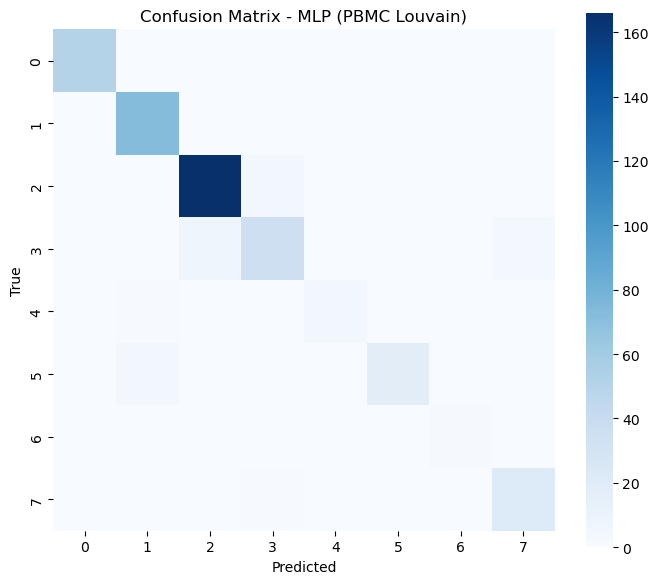

Saved: results/figures/mlp_confusion_matrix.png


In [19]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, cmap="Blues", square=True)
plt.title("Confusion Matrix - MLP (PBMC Louvain)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("results/figures/mlp_confusion_matrix.png", dpi=200)
plt.show()

print("Saved: results/figures/mlp_confusion_matrix.png")